In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [186]:
# hyperparams
my_seed = 881003
valid_ratio = 0.2
eps = 1e-8
min_clip_value = 1e-5
max_clip_value = 1 - 1e-5
X_train_fpath = './data/X_train'
y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
y_test_fpath = './output_{}.csv'

In [187]:
# set numpy seed
np.random.seed(my_seed)

In [188]:
# read datasets
X_train = pd.read_csv(X_train_fpath, index_col=['id'])
X_test = pd.read_csv(X_test_fpath, index_col=['id'])
y_train = pd.read_csv(y_train_fpath, index_col=['id']).to_numpy().astype('float64').flatten()

In [189]:
train_size = X_train.shape[0]

In [190]:
X = pd.concat([X_train, X_test])

In [129]:
count = X.nunique()
one = count[count == 1].index
two = count[count == 2].index
three_or_more = count[count >= 3].index

In [130]:
X = X.drop(columns=one)
X[three_or_more] = (X[three_or_more] - X[three_or_more].mean()) / X[three_or_more].std()

In [191]:
#X = (X - X.mean()) / (X.std() + 1e-8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]

In [192]:
X_train = X_train.to_numpy().astype('float64')
X_test = X_test.to_numpy().astype('float64')

In [193]:
# define some helper function as we can't use sklearn...
# not needed
def normalize(X, is_train=True, columns=None, X_mean=None, X_std=None):
    if columns is None:
        columns = np.arange(X.shape[1])
    if is_train:
        X_mean = np.mean(X[:, columns], axis=0).reshape(1, -1)
        X_std = np.std(X[:, columns], axis=0).reshape(1, -1)
    X[:, columns] = (X[:, columns] - X_mean) / (X_std + eps)
    return X, X_mean, X_std # X_mean, X_std: (1 * feature_num)
def train_test_split(X, y, test_size=0.25):
    permu = np.arange(X.shape[0])#np.random.permutation(X.shape[0])
    train_size = int(X.shape[0] * (1 - test_size) + 0.5)
    return X[permu[:train_size]], X[permu[train_size:]], y[permu[:train_size]], y[permu[train_size:]]

In [194]:
# Normalize them and split into train and validate
#X_train, X_mean, X_std = normalize(X_train)
#X_test, _, _ = normalize(X_test, is_train=False, X_mean=X_mean, X_std=X_std)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_ratio)

# Check shapes
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(43405, 510) (10851, 510) (43405,) (10851,)


In [195]:
# helper function for training
def shuffle(X, y):
    permu = np.random.permutation(X.shape[0])
    return (X[permu], y[permu])
def sigmoid(z):
    return np.clip(1 / (1.0 + np.exp(-z)), min_clip_value, max_clip_value)
def accuracy(y_pred, y_true):
    return 1.0 - np.mean(np.abs(y_pred - y_true))
def cross_entropy_loss(y_pred, y_true):
    return -np.dot(y_true, np.log(y_pred)) - np.dot((1 - y_true), np.log(1 - y_pred))

In [196]:
class LogisticRegression:
    def __init__(self):
        self.w = None
        self.b = None
    def f(self, X, w, b):
        return sigmoid(X @ w + b)
    def predict(self, X, w, b):
        return np.round(self.f(X, w, b)).astype(np.int)
    def predict_f(self, X):
        return np.round(self.f(X, self.w, self.b)).astype(np.int)
    def gradient(self, X, y, w, b, lamb):
        y_pred = self.f(X, w, b)
        y_diff = y - y_pred
        w_grad = -np.sum(y_diff * X.T, axis=1) - 2 * lamb * w
        b_grad = -np.sum(y_diff)
        return (w_grad, b_grad)
    def fit(self, X_train, y_train, X_valid=None, y_valid=None, epochs=10, batch_size=10, learning_rate=0.2, print_every=1, lamb=0):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        w, b = np.zeros((X_train.shape[1],)), np.zeros((1,))
        step, bst, bstf, bt = 1, 0, None, 0
        mw, mb = np.zeros((X_train.shape[1],)), np.zeros((1,))
        vw, vb = np.zeros((X_train.shape[1],)), np.zeros((1,))
        b1, b2, eps = 0.9, 0.999, 1e-9
        
        for epoch in range(epochs):
            X_train, y_train = shuffle(X_train, y_train)
            for i in range(0, X_train.shape[0], batch_size):
                X = X_train[i * batch_size:(i + 1) * batch_size]
                y = y_train[i * batch_size:(i + 1) * batch_size]
        
                w_grad, b_grad = self.gradient(X, y, w, b, lamb)
            
                #mw = mw * b1 + w_grad * (1 - b1)
                #vw = vw * b2 + w_grad ** 2 * (1 - b2)
                #mhat = mw / (1 - b1)
                #vhat = vw / (1 - b2)              
                #w -= learning_rate * mhat / (np.sqrt(vhat) + eps)
                #
                #mb = mb * b1 + b_grad * (1 - b1)
                #vb = vb * b2 + b_grad ** 2 * (1 - b2)
                #mhat = mb / (1 - b1)
                #vhat = vb / (1 - b2)              
                #b -= learning_rate * mhat / (np.sqrt(vhat) + eps)
                
                w -= learning_rate / np.sqrt(step) * w_grad
                b -= learning_rate / np.sqrt(step) * b_grad
                
                step += 1
        
            y_pred = self.f(X_train, w, b)
            train_loss.append(cross_entropy_loss(y_pred, y_train) / X_train.shape[0])
            train_acc.append(accuracy(np.round(y_pred), y_train))
            
            if X_valid is not None:
                y_pred = self.f(X_valid, w, b)
                valid_loss.append(cross_entropy_loss(y_pred, y_valid) / X_valid.shape[0])
                valid_acc.append(accuracy(np.round(y_pred), y_valid))
            
                if valid_acc[-1] > bst:
                    bst = valid_acc[-1]
                    bstf = (w, b)
                    bt = epoch

            if (epoch + 1) % print_every == 0:
                if X_valid is not None:
                    print(epoch, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1])
                else:
                    print(epoch, train_loss[-1], train_acc[-1])
        
        if X_valid is not None:
            self.w = bstf[0]
            self.b = bstf[1]
            print(bt)
        else:
            self.w = w
            self.b = b
        return train_loss, train_acc, valid_loss, valid_acc
                

In [197]:
model = LogisticRegression()

In [198]:
train_loss, train_acc, valid_loss, valid_acc = model.fit(X_train, y_train, X_valid, y_valid, batch_size=10, epochs=100, print_every=10, learning_rate=0.5, lamb=0)

/home/robert1003/milk/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


9 2.8922169372533775 0.7477479553046884 2.980613130824058 0.7403004331398028
19 2.9727507590963 0.7400069116461236 3.045734001811946 0.7338494148004793
29 2.973884960799868 0.7386706600622048 3.0590815560034716 0.7308082204405124
39 2.5968903723075134 0.7712705909457436 2.644944379525962 0.7669339231407244
49 2.3748138637063416 0.7906923165533924 2.3969533333422435 0.788959542899272
59 3.200085844325052 0.716392120723419 3.282118527947216 0.7090590728965072
69 2.2804738375028157 0.798249049648658 2.3404752220006944 0.7934752557367984
79 2.4801107322924323 0.7797488768575049 2.4971372101251634 0.777624182103032
89 2.5173967927046834 0.7789425181430711 2.552118506227164 0.7754124043866925
99 2.4144572883328443 0.7858311254463771 2.43024831909199 0.784351672656898
69


In [199]:
print(valid_loss[69], valid_acc[69])

2.3404752220006944 0.7934752557367984


49 0.26924322886952073 0.8833314134316324 0.2831120768426481 0.874112984978343
99 0.26763492656662585 0.8842760050685405 0.2813285005893357 0.876232605289835
97
49 0.2810078306946139 0.8815113466190531 0.29640841318868916 0.8726384665007834
99 0.28814719315031434 0.881856928925239 0.3043685804803909 0.8730070961201732
19
49 0.26908846935671193 0.8835387628153438 0.2838935491616583 0.8766012349092249
99 0.2679137551917978 0.8833314134316324 0.2826404776099715 0.8752188738365128
70
49 0.2688515511236549 0.8839765004031793 0.28285629765993137 0.8748502442171229
99 0.2685544228014767 0.8835618016357563 0.2820719254687336 0.8756796608607502
60


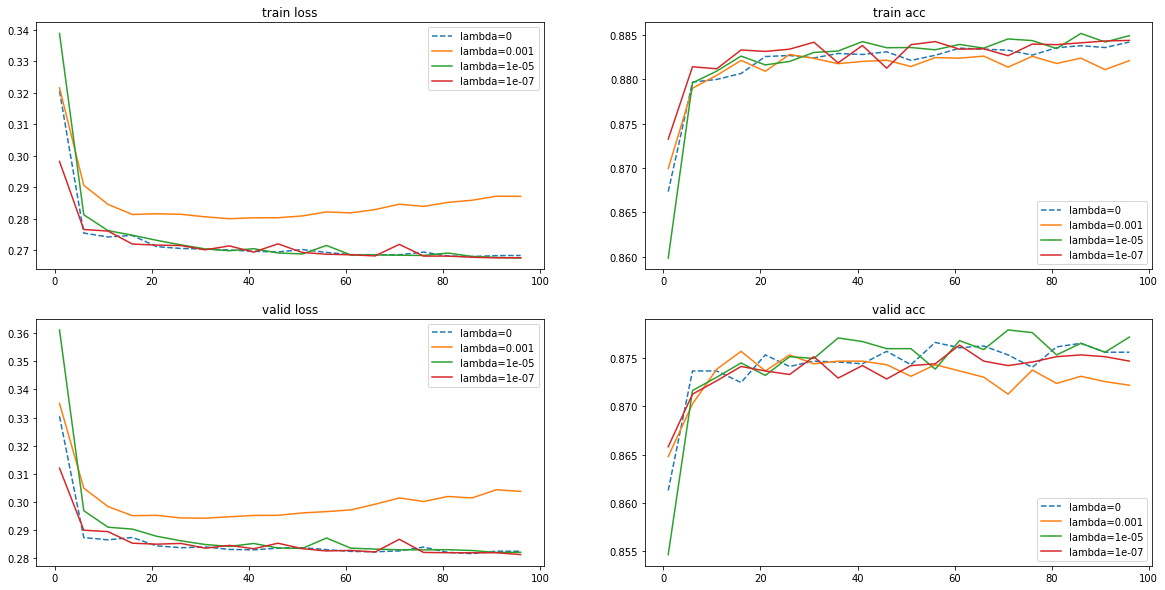

In [166]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
train_loss, train_acc, valid_loss, valid_acc = model.fit(
    X_train, y_train, X_valid, y_valid, 
    batch_size=10, epochs=100, print_every=50, learning_rate=0.5, lamb=0.0
)
axs[0][0].plot(np.arange(1, 101, 5), train_loss[::5], '--', label='lambda=0')
axs[0][1].plot(np.arange(1, 101, 5), train_acc[::5], '--', label='lambda=0')
axs[1][0].plot(np.arange(1, 101, 5), valid_loss[::5], '--', label='lambda=0')
axs[1][1].plot(np.arange(1, 101, 5), valid_acc[::5], '--', label='lambda=0')

lambs = [1e-3, 1e-5, 1e-7]
for lamb in lambs:
    train_loss, train_acc, valid_loss, valid_acc = model.fit(
        X_train, y_train, X_valid, y_valid, 
        batch_size=10, epochs=100, print_every=50, learning_rate=0.5, lamb=lamb
    )
    axs[0][0].plot(np.arange(1, 101, 5), train_loss[::5], label=f'lambda={lamb}')
    axs[0][1].plot(np.arange(1, 101, 5), train_acc[::5], label=f'lambda={lamb}')
    axs[1][0].plot(np.arange(1, 101, 5), valid_loss[::5], label=f'lambda={lamb}')
    axs[1][1].plot(np.arange(1, 101, 5), valid_acc[::5], label=f'lambda={lamb}')
    
axs[0][0].legend(loc="upper right")
axs[0][0].set_title('train loss')
axs[0][1].legend(loc="lower right")
axs[0][1].set_title('train acc')
axs[1][0].legend(loc="upper right")
axs[1][0].set_title('valid loss')
axs[1][1].legend(loc="lower right")
axs[1][1].set_title('valid acc')
plt.savefig('p2.png')
plt.show()

In [52]:
tl, ta, _, _ = model.fit(X_train, y_train, batch_size=10, epochs=60, print_every=1, learning_rate=0.5)
print(tl[-1], ta[-1])

/home/robert1003/milk/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


0 1.3832528658491976 0.8336405190209377
1 1.0438335703817603 0.8559421999410204
2 0.9368526950264037 0.8588543202595105
3 0.8545276163371321 0.865526393394279
4 0.8020325855579814 0.8673326452373931
5 0.7561609182483832 0.8693600707755824
6 0.7272196332167395 0.8703922146859333
7 0.6855621983477129 0.8709451489236213
8 0.670026990657142 0.8696918313181952
9 0.6414881611621003 0.8727882630492481
10 0.6291919896037221 0.8699867295782955
11 0.6156024741866268 0.8690651725154821
12 0.590163894497787 0.8748525508699498
13 0.5901137586537715 0.8699498672957829
14 0.565573977626202 0.8718667059864347
15 0.5553733737554092 0.8712400471837216
16 0.5398827515049139 0.870576526098496
17 0.5195128888692855 0.8740047183721615
18 0.5117572745602812 0.8751105868475376
19 0.4996307519765907 0.8742996166322619
20 0.4926810674238412 0.8735623709820112
21 0.4836952205631956 0.8736360955470363
22 0.47272788998379683 0.873820406959599
23 0.46537844697365777 0.8740047183721615
24 0.46127302724921937 0.87584

KeyboardInterrupt: 

In [97]:
y_test_pred = pd.DataFrame(model.predict_f(X_test).transpose())
y_test_pred.columns = ['label']
y_test_pred['id'] = range(0, X_test.shape[0])
y_test_pred = y_test_pred.reindex(columns=['id', 'label'])
y_test_pred.to_csv(y_test_fpath.format('logistic'), index=None)